<a href="https://colab.research.google.com/github/szklipy/F1_driver_standings_predictor/blob/main/F1_Driver_standings_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set()
import os

from pandas.plotting import scatter_matrix

In [3]:
drivers = pd.read_csv('/content/drive/MyDrive/bev gépi tanulás/adathalmazok/drivers.csv')
driver_result = pd.read_csv('/content/drive/MyDrive/bev gépi tanulás/adathalmazok/results.csv')
races = pd.read_csv('/content/drive/MyDrive/bev gépi tanulás/adathalmazok/races.csv')
circuits = pd.read_csv('/content/drive/MyDrive/bev gépi tanulás/adathalmazok/circuits.csv')
driver_standings = pd.read_csv('/content/drive/MyDrive/bev gépi tanulás/adathalmazok/driver_standings.csv')
laptimes = pd.read_csv('/content/drive/MyDrive/bev gépi tanulás/adathalmazok/lap_times.csv')
qualifying = pd.read_csv('/content/drive/MyDrive/bev gépi tanulás/adathalmazok/qualifying.csv')

In [ ]:
drivers.head()

In [ ]:
driver_result.head()

In [ ]:
races_date = races[['date','circuitId','raceId']]
races_date['date'] = pd.to_datetime(races_date['date'])

#2023-as szezon törlése 
races_date = races_date[(races_date['date'].dt.year!=2023)]
races_date

In [ ]:
circuits = pd.read_csv('/content/drive/MyDrive/bev gépi tanulás/adathalmazok/circuits.csv')
#csak a 2023as szezon versenypályái legyenek benne
this_season_circuitsId = [2,74,0,71,76,20,5,3,6,69,8,10,12,38,13,14,21,75,68,31,17,22,23]
columns_we_need = ['circuitId','circuitRef','name','location','country',]# többi oszlop fölösleges
circuits_df = pd.DataFrame(circuits,index=this_season_circuitsId,columns=columns_we_need)
circuits_df

In [ ]:
circuits.head()

In [ ]:
driver_standings.head()

In [ ]:
laptimes = laptimes[['raceId','driverId','lap','milliseconds']]
laptimes.head()

In [ ]:
qualifying = qualifying[['driverId','position']]
qualifying.head()

In [ ]:
df1 = pd.merge(driver_result, races, on ='raceId')
df_race= pd.merge(df1, drivers, on = 'driverId')
df_race
#:)

In [ ]:
#Drop posterior data column (time, milliseconds, fastestLap, fastestLapTime, fastestLapSpeed, statusId)
posterior_data = ['laps', 'milliseconds', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'statusId', 'time_x', 'time_y', 'positionOrder']
df_race = df_race.drop(columns=posterior_data)
df_race

In [ ]:
#Drop redundant positon and positionText column
df_race = df_race.drop(columns=['position',  'positionText', 'number_x', 'sprint_date', 'sprint_time', 'driverRef', 'number_y', 'nationality', 'url_x', 'url_y', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'quali_date', 'quali_time', 'fp3_date', 'fp3_time', 'name'])
df_race

In [11]:
#Change data type from string to datetime
df_race['dob'] = pd.to_datetime(df_race['dob'])
df_race['date'] = pd.to_datetime(df_race['date'])

In [12]:
#Add age column to dataframe
dates = datetime.today()-df_race['dob']
age = dates.dt.days/365
df_race['age'] = round(age)
df_race.head()

,resultId,raceId,driverId,constructorId,grid,points,rank,year,round,circuitId,date,code,forename,surname,dob,age
0,1,18,1,1,1,10.0,2,2008,1,1,2008-03-16,HAM,Lewis,Hamilton,1985-01-07,38.0
1,27,19,1,1,9,4.0,3,2008,2,2,2008-03-23,HAM,Lewis,Hamilton,1985-01-07,38.0
2,57,20,1,1,3,0.0,19,2008,3,3,2008-04-06,HAM,Lewis,Hamilton,1985-01-07,38.0
3,69,21,1,1,5,6.0,3,2008,4,4,2008-04-27,HAM,Lewis,Hamilton,1985-01-07,38.0
4,90,22,1,1,3,8.0,2,2008,5,5,2008-05-11,HAM,Lewis,Hamilton,1985-01-07,38.0


In [13]:
###WINNING RATE

# INITIALISATION
df_driver = drivers.copy()
df_driver['totalWins'] = 0

race_dates = races[['raceId','date']]
# CLEANING AND ADDING

# adding dates to each race
driver_standings = driver_standings.merge(race_dates[['raceId', 'date']], how='left', on='raceId')

# Convert the "date" column to a datetime object
driver_standings['date'] = pd.to_datetime(driver_standings['date'])

# Create a new column 'year' to extract the year from the 'date' column
driver_standings['year'] = driver_standings['date'].dt.year
# driver_standings_csv.head()

# count the number of races each driver has driven in
num_races_per_driver = driver_standings.groupby('driverId')['raceId'].nunique()
num_races_per_driver_df = num_races_per_driver.reset_index()
num_races_per_driver_df = num_races_per_driver_df.rename(columns={'raceId': 'totalRaces'})
# num_races_per_driver_df.head()

# FINDING TOTAL WINS FOR EACH DRIVER
for index, row in df_driver.iterrows():
    driverId = row['driverId']

    # filtering out rows with ['driverId'] == driverId
    driver_standings_csv_driverId = driver_standings[driver_standings['driverId'] == driverId]

    # Group the dataframe by year and find the maximum date for each year
    latest_day_in_year = driver_standings_csv_driverId.groupby(driver_standings_csv_driverId['date'].dt.year)['date'].max()

    # Use the latest day in each year to filter the original dataframe
    filtered_dataframe = driver_standings_csv_driverId.loc[driver_standings_csv_driverId['date'].isin(latest_day_in_year)]

    total_wins = filtered_dataframe['wins'].sum()
    
    index = df_driver.index[df_driver['driverId'] == driverId].tolist()[0]
    df_driver.at[index, 'totalWins'] = total_wins


# adding dates to each race
df_driver = df_driver.merge(num_races_per_driver_df, how='left', on='driverId')

# calculate win rate and drop totalWins columns
df_driver['winRate'] = df_driver['totalWins'] / df_driver['totalRaces']
df_driver = df_driver.drop(['totalWins'], axis=1)
df_driver['dob'] = pd.to_datetime(df_driver['dob'])
df_driver['age'] = 2023 - df_driver['dob'].dt.year
    
# PRINT CURRENT DATASET    
df_driver.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url,totalRaces,winRate,age
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,311.0,0.331190,38
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld,194.0,0.000000,46
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg,206.0,0.111650,38
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso,361.0,0.088643,42
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen,111.0,0.009009,42


In [14]:
###FASTEST LAPTIME WINING RATE


# Group the dataframe by raceId and find the index of the row with the minimum milliseconds
idx = laptimes.groupby('raceId')['milliseconds'].idxmin()

# Use the index to select the rows with the minimum milliseconds for each raceId
df_min_milliseconds = laptimes.loc[idx]

# Sort the result by raceId
df_min_milliseconds.sort_values('raceId', inplace=True)

counts = pd.DataFrame(df_min_milliseconds['driverId'].value_counts())
counts.columns = ['totalFastestLaps']
counts['driverId'] = counts.index
counts.reset_index(drop=True, inplace=True)

# adding totalFastestLaps to df maindata_wnames
df_driver = df_driver.merge(counts, how='left', on='driverId')
df_driver = df_driver.fillna(0)

# calculate fastest lap rate and drop totalFastestLaps
df_driver['fastestLapRate'] = df_driver['totalFastestLaps'] / df_driver['totalRaces']
df_driver = df_driver.drop(['totalFastestLaps'], axis=1)

# PRINT CURRENT DATASET    
df_driver.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url,totalRaces,winRate,age,fastestLapRate
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,311.0,0.331190,38,0.192926
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld,194.0,0.000000,46,0.010309
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg,206.0,0.111650,38,0.097087
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso,361.0,0.088643,42,0.063712
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen,111.0,0.009009,42,0.018018


In [15]:
#### QUALIFYING WINNING RATE


# COUNTING THE NUMBER OF QUALIFYING WINS
# Group by driverId and position, then count the number of occurrences
position_1_counts = qualifying[qualifying['position'] == 1].groupby('driverId')['position'].count().reset_index()

# Rename the 'position' column to 'position_1_count'
position_1_counts = position_1_counts.rename(columns={'position': 'position_1_count'})

# # Print the resulting DataFrame
# position_1_counts.head()

# merge
df_driver = df_driver.merge(position_1_counts, how='left', on='driverId')
df_driver = df_driver.fillna(0)

# calculate fastest lap rate and drop totalFastestLaps
df_driver['qualifyingWinRate'] = df_driver['position_1_count'] / df_driver['totalRaces']
df_driver = df_driver.drop(['position_1_count'], axis=1)

# filling in NaN values for qualifyingWinRate
df_driver.fillna(0, inplace=True)

df_driver.head()



,driverId,driverRef,number,code,forename,surname,dob,nationality,url,totalRaces,winRate,age,fastestLapRate,qualifyingWinRate
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,311.0,0.331190,38,0.192926,0.340836
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld,194.0,0.000000,46,0.010309,0.005155
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg,206.0,0.111650,38,0.097087,0.145631
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso,361.0,0.088643,42,0.063712,0.063712
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen,111.0,0.009009,42,0.018018,0.009009


In [65]:
#ez a saját szrom, hogy azok a pilóták akik most vannak
this_season_driversId = [0,845,828,813,842,830,3,838,850,854,844,855,837,840,853,820,856,846,806,823]
columns_we_need = ['driverId','number','forename','surname','nationality','dob']
this_season_drivers_df = pd.DataFrame(drivers,index=this_season_driversId,columns=columns_we_need)
print(this_season_drivers_df)

     driverId number   forename     surname nationality         dob
0           1     44      Lewis    Hamilton     British  1985-01-07
845       847     63     George     Russell     British  1998-02-15
828       830     33        Max  Verstappen       Dutch  1997-09-30
813       815     11     Sergio       Pérez     Mexican  1990-01-26
842       844     16    Charles     Leclerc  Monegasque  1997-10-16
830       832     55     Carlos       Sainz     Spanish  1994-09-01
3           4     14   Fernando      Alonso     Spanish  1981-07-29
838       840     18      Lance      Stroll    Canadian  1998-10-29
850       852     22       Yuki     Tsunoda    Japanese  2000-05-11
854       856     45       Nyck    de Vries       Dutch  1995-02-06
844       846      4      Lando      Norris     British  1999-11-13
855       857     81      Oscar     Piastri  Australian  2001-04-06
837       839     31    Esteban        Ocon      French  1996-09-17
840       842     10     Pierre       Gasly     

In [66]:
#merge, arra a pilótákra akik most vannak
this_season_drivers = pd.merge(this_season_drivers_df,df_driver,on='driverId')
this_season_drivers

,driverId,number_x,forename_x,surname_x,nationality_x,dob_x,driverRef,number_y,code,forename_y,surname_y,dob_y,nationality_y,url,totalRaces,winRate,age,fastestLapRate,qualifyingWinRate
0,1,44,Lewis,Hamilton,British,1985-01-07,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,311.0,0.331190,38,0.192926,0.340836
1,847,63,George,Russell,British,1998-02-15,russell,63,RUS,George,Russell,1998-02-15,British,http://en.wikipedia.org/wiki/George_Russell_%2...,83.0,0.012048,25,0.060241,0.012048
2,830,33,Max,Verstappen,Dutch,1997-09-30,max_verstappen,33,VER,Max,Verstappen,1997-09-30,Dutch,http://en.wikipedia.org/wiki/Max_Verstappen,164.0,0.213415,26,0.140244,0.121951
3,815,11,Sergio,Pérez,Mexican,1990-01-26,perez,11,PER,Sergio,Pérez,1990-01-26,Mexican,http://en.wikipedia.org/wiki/Sergio_P%C3%A9rez,240.0,0.016667,33,0.037500,0.004167
4,844,16,Charles,Leclerc,Monegasque,1997-10-16,leclerc,16,LEC,Charles,Leclerc,1997-10-16,Monegasque,http://en.wikipedia.org/wiki/Charles_Leclerc,104.0,0.048077,26,0.067308,0.163462
5,832,55,Carlos,Sainz,Spanish,1994-09-01,sainz,55,SAI,Carlos,Sainz,1994-09-01,Spanish,http://en.wikipedia.org/wiki/Carlos_Sainz_Jr.,164.0,0.006098,29,0.018293,0.012195
6,4,14,Fernando,Alonso,Spanish,1981-07-29,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso,361.0,0.088643,42,0.063712,0.063712
7,840,18,Lance,Stroll,Canadian,1998-10-29,stroll,18,STR,Lance,Stroll,1998-10-29,Canadian,http://en.wikipedia.org/wiki/Lance_Stroll,124.0,0.000000,25,0.000000,0.008065
8,852,22,Yuki,Tsunoda,Japanese,2000-05-11,tsunoda,22,TSU,Yuki,Tsunoda,2000-05-11,Japanese,http://en.wikipedia.org/wiki/Yuki_Tsunoda,45.0,0.000000,23,0.000000,0.000000
9,856,45,Nyck,de Vries,Dutch,1995-02-06,de_vries,45,DEV,Nyck,de Vries,1995-02-06,Dutch,http://en.wikipedia.org/wiki/Nyck_de_Vries,8.0,0.000000,28,0.000000,0.000000


In [18]:
#itt majd nekem be kéne állítani arra, hogy a 23as szezon pályái és pilótái
#Number of data point
print("Number of data point for race dataframe: " + str(df_race.shape[0]))
print("Number of data point for driver dataframe: " + str(df_driver.shape[0]))

Number of data point for race dataframe: 25840
Number of data point for driver dataframe: 857


In [19]:
print("Data frame race information")
df_race.info()

print('\n\n')
print("Data frame driver information")
df_driver.info()

Data frame race information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25840 entries, 0 to 25839
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   resultId       25840 non-null  int64         
 1   raceId         25840 non-null  int64         
 2   driverId       25840 non-null  int64         
 3   constructorId  25840 non-null  int64         
 4   grid           25840 non-null  int64         
 5   points         25840 non-null  float64       
 6   rank           25840 non-null  object        
 7   year           25840 non-null  int64         
 8   round          25840 non-null  int64         
 9   circuitId      25840 non-null  int64         
 10  date           25840 non-null  datetime64[ns]
 11  code           25840 non-null  object        
 12  forename       25840 non-null  object        
 13  surname        25840 non-null  object        
 14  dob            25840 non-null  datetime64[

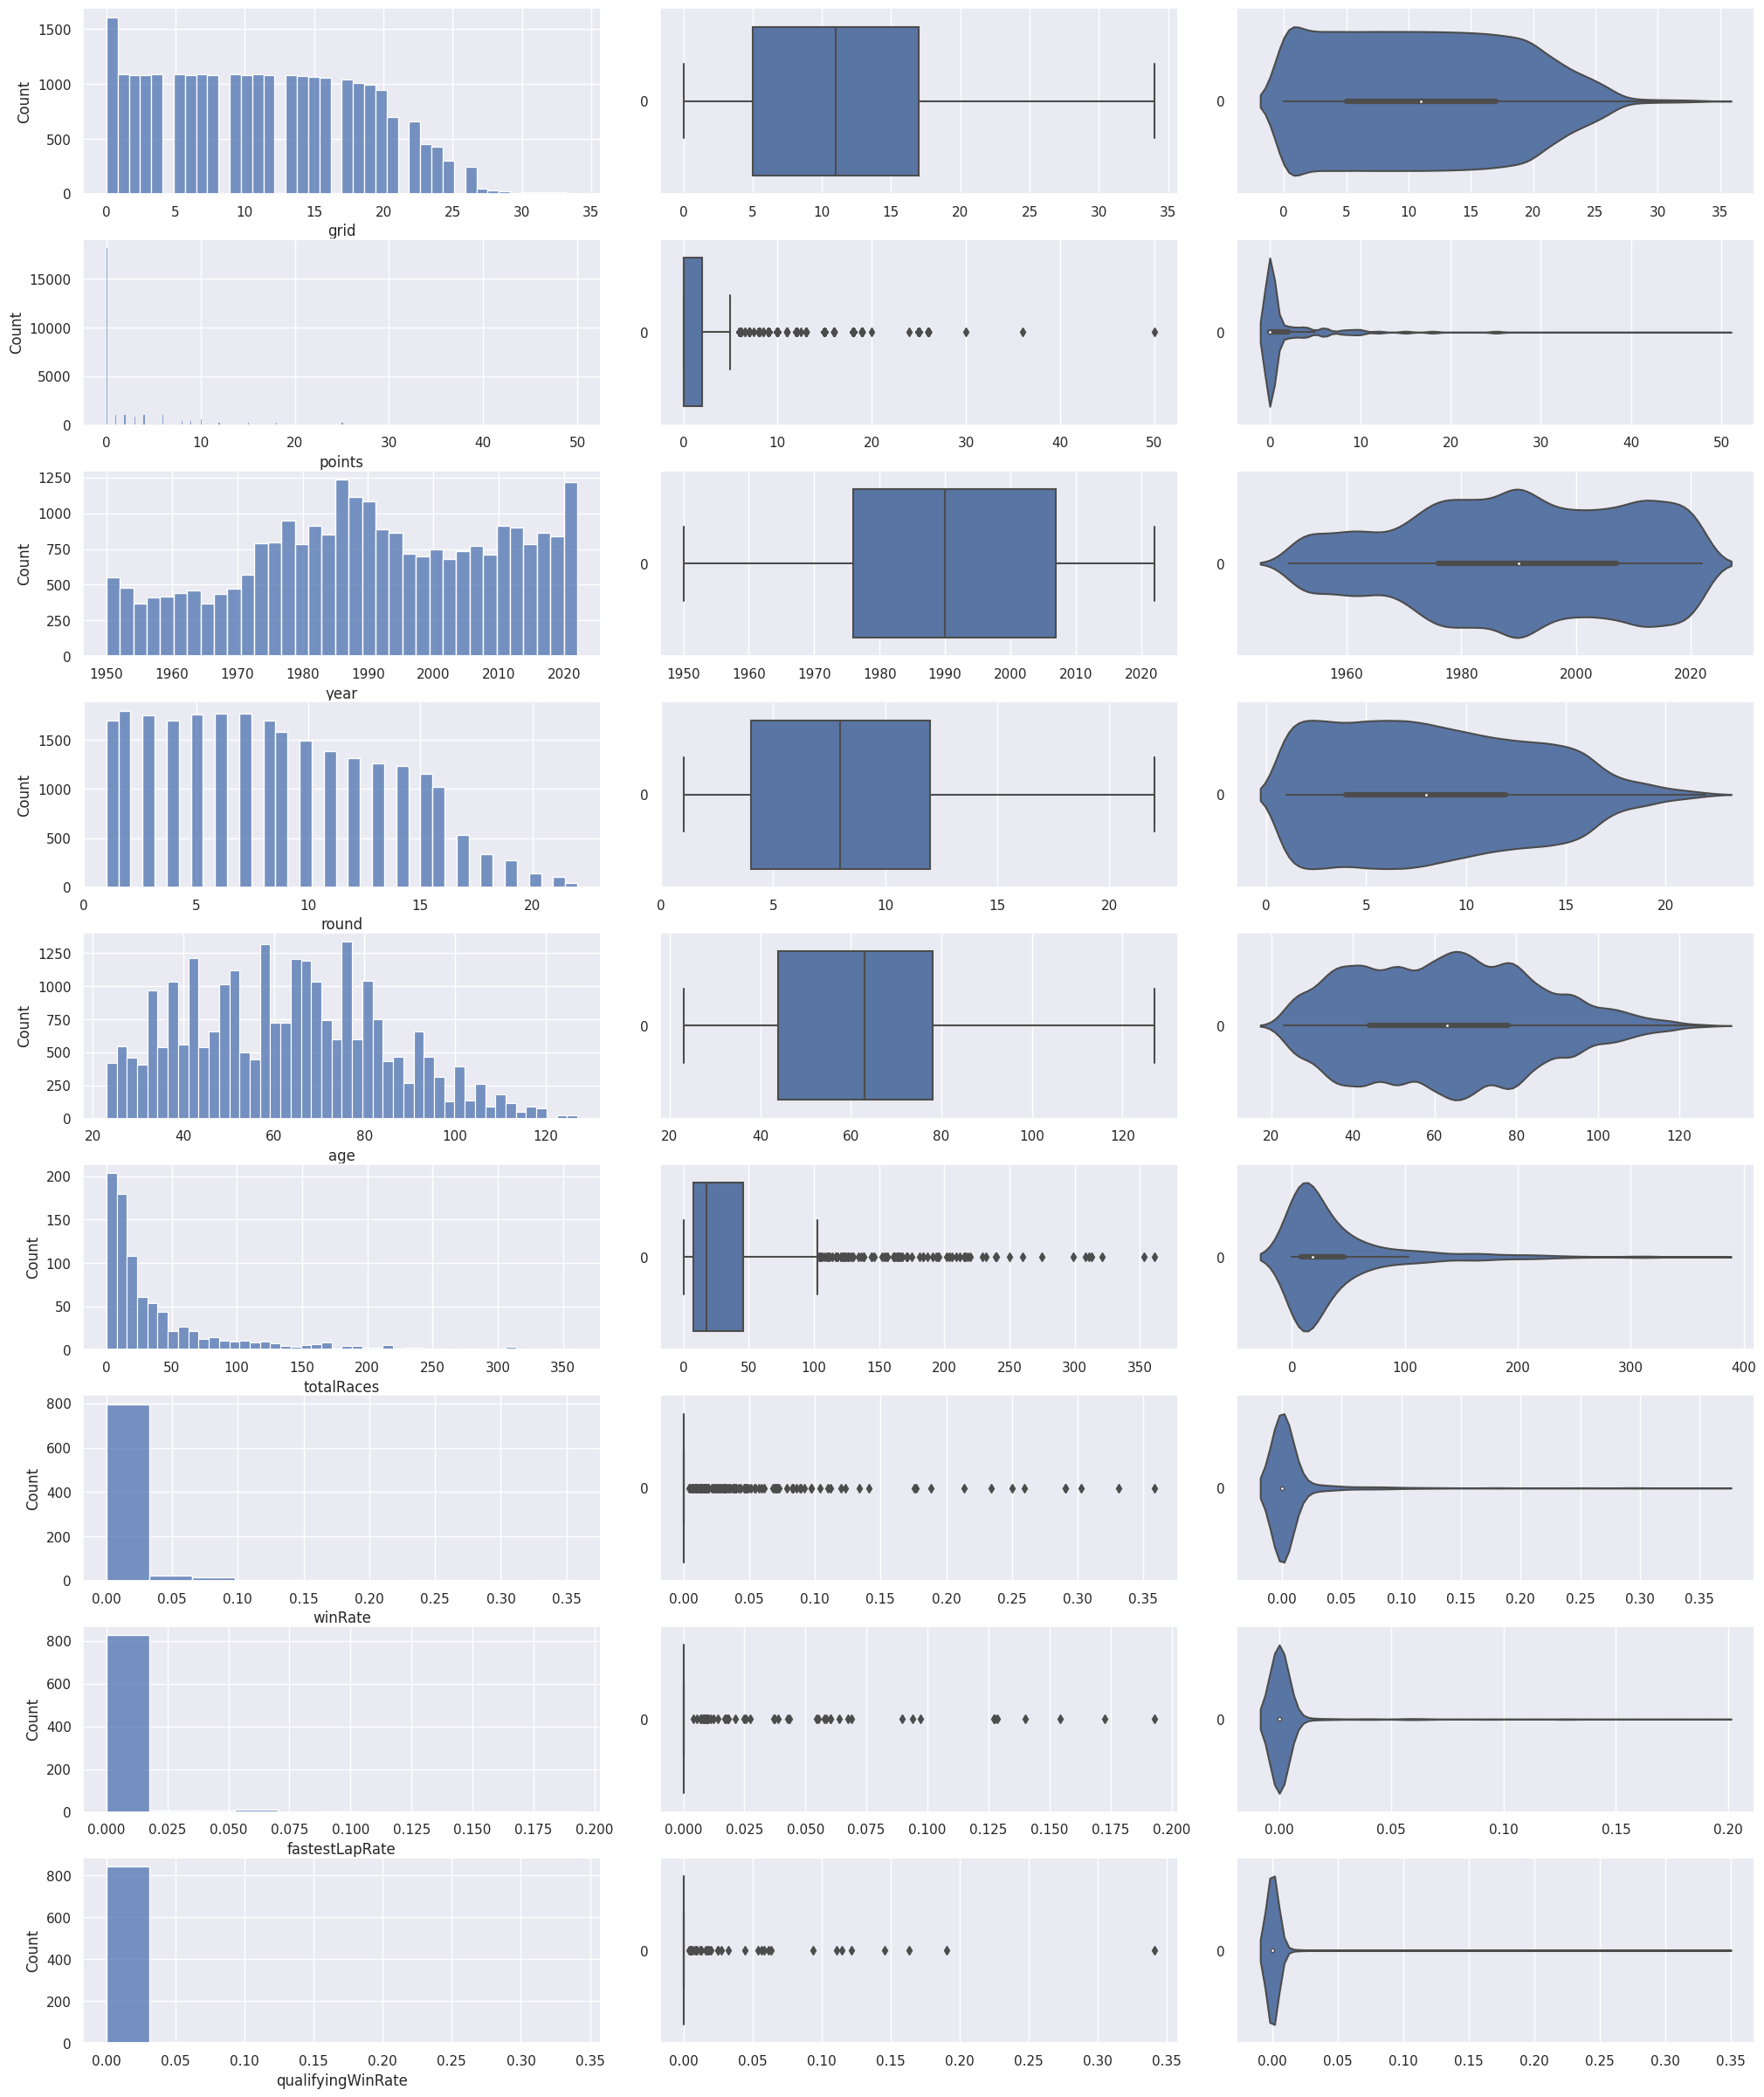

In [20]:
# plotting the distributions of the level variables
f, axes = plt.subplots(9, 3, figsize=(20, 24))

df_numeric = pd.DataFrame(df_race[['grid', 'points', 'year', 'round', 'age']])
# Format the layout so that no overlapping between titles and graphs
df_numeric_1 = pd.DataFrame(df_driver[['totalRaces', 'winRate', 'fastestLapRate', 'qualifyingWinRate']])
plt.tight_layout()
count = 0

for var in df_numeric:
    sns.histplot(data = df_numeric[var], ax = axes[count,0])
    sns.boxplot(data = df_numeric[var], orient = "h", ax = axes[count,1])
    sns.violinplot(data = df_numeric[var], orient = "h", ax = axes[count,2])
    count += 1
    
for var in df_numeric_1:
    sns.histplot(data = df_numeric_1[var], ax = axes[count,0])
    sns.boxplot(data = df_numeric_1[var], orient = "h", ax = axes[count,1])
    sns.violinplot(data = df_numeric_1[var], orient = "h", ax = axes[count,2])
    count += 1

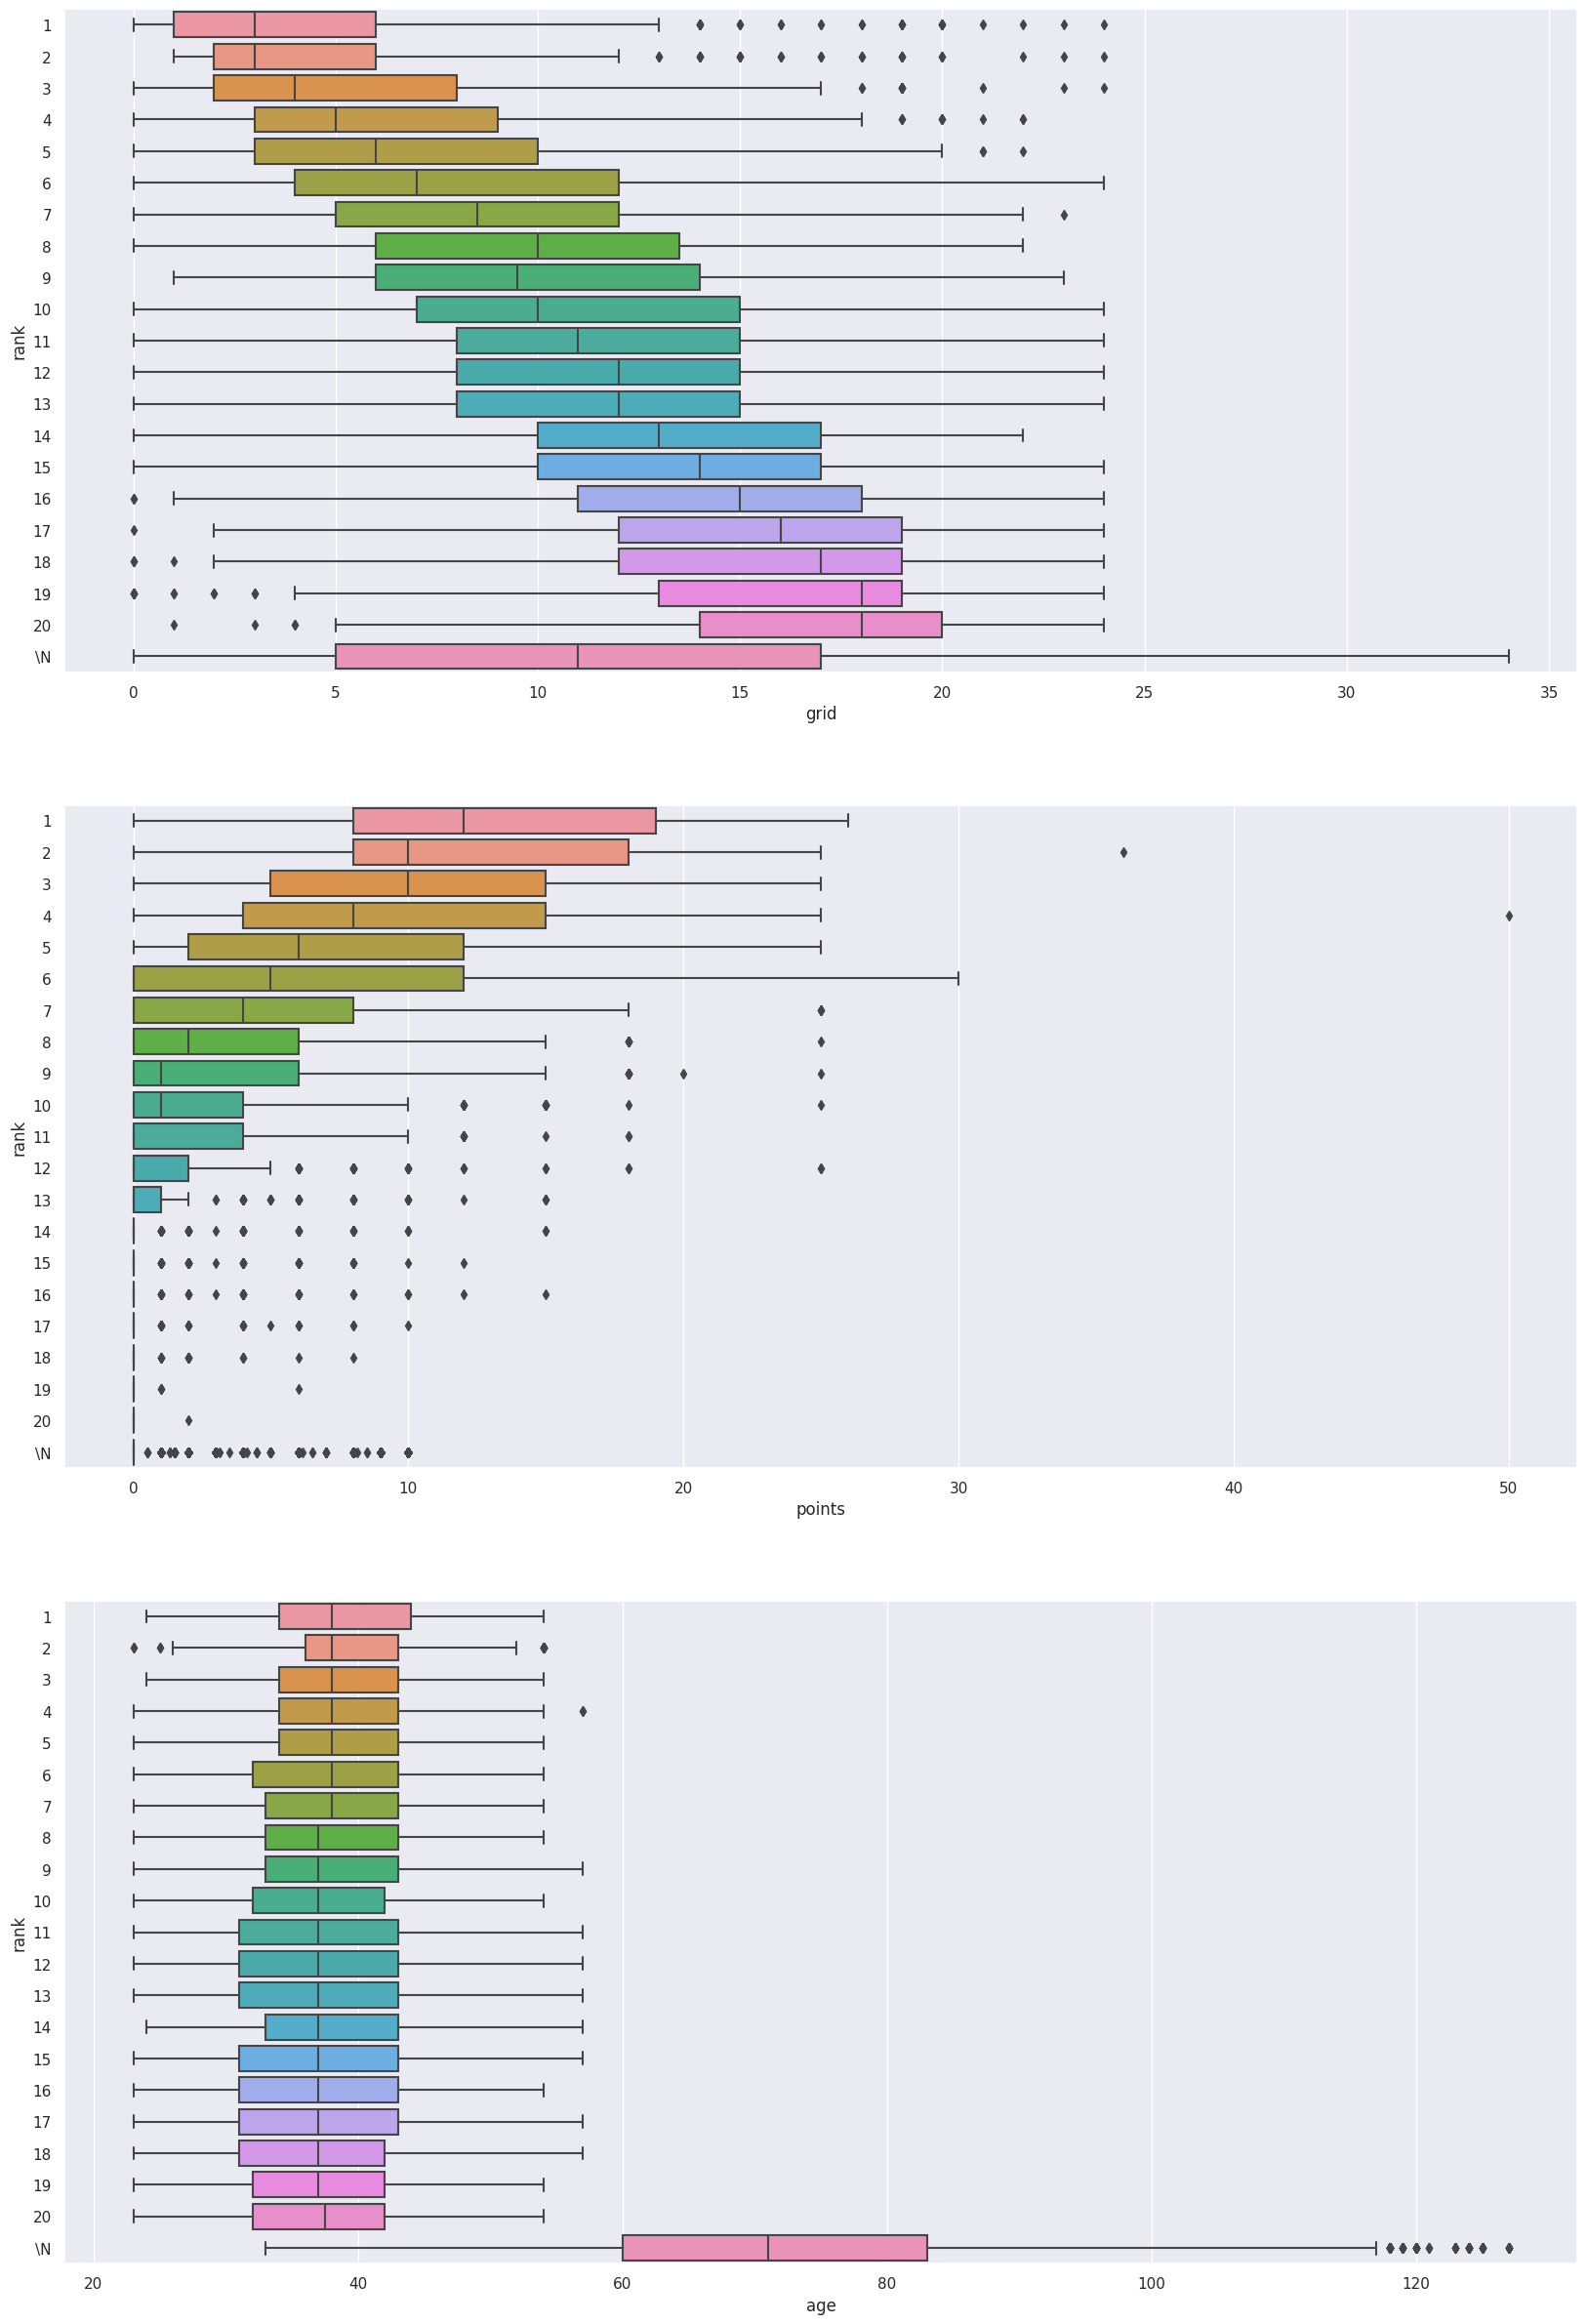

In [21]:
#Categorical Value
f, axes = plt.subplots(3, 1, figsize=(20, 30))
df_cat = pd.DataFrame(df_race[['grid', 'points', 'age', 'rank']])
count = 0
for col in df_cat:
    if col!='rank':
        sns.boxplot(data=df_race, x=col, y='rank', order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17','18', '19', '20', '\\N'], ax=axes[count])
        count = count + 1

In [22]:
df_race.describe()

,resultId,raceId,driverId,constructorId,grid,points,year,round,circuitId,age
count,25840.000000,25840.000000,25840.000000,25840.000000,25840.000000,25840.000000,25840.000000,25840.000000,25840.000000,25840.000000
mean,12921.334327,531.425813,261.732082,48.628328,11.179063,1.877053,1990.251780,8.385991,23.486920,62.672368
std,7460.682031,299.440908,268.623016,59.732131,7.243725,4.169849,19.345632,4.958210,18.569371,21.738271
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1950.000000,1.000000,1.000000,23.000000
25%,6460.750000,293.000000,56.000000,6.000000,5.000000,0.000000,1976.000000,4.000000,9.000000,44.000000
50%,12920.500000,514.000000,163.000000,25.000000,11.000000,0.000000,1990.000000,8.000000,18.000000,63.000000
75%,19380.250000,784.000000,360.000000,58.000000,17.000000,2.000000,2007.000000,12.000000,34.000000,78.000000
max,25845.000000,1096.000000,856.000000,214.000000,34.000000,50.000000,2022.000000,22.000000,79.000000,127.000000


<ipython-input-23-6797a78c75f4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_race.corr(),annot=True)


<Axes: >

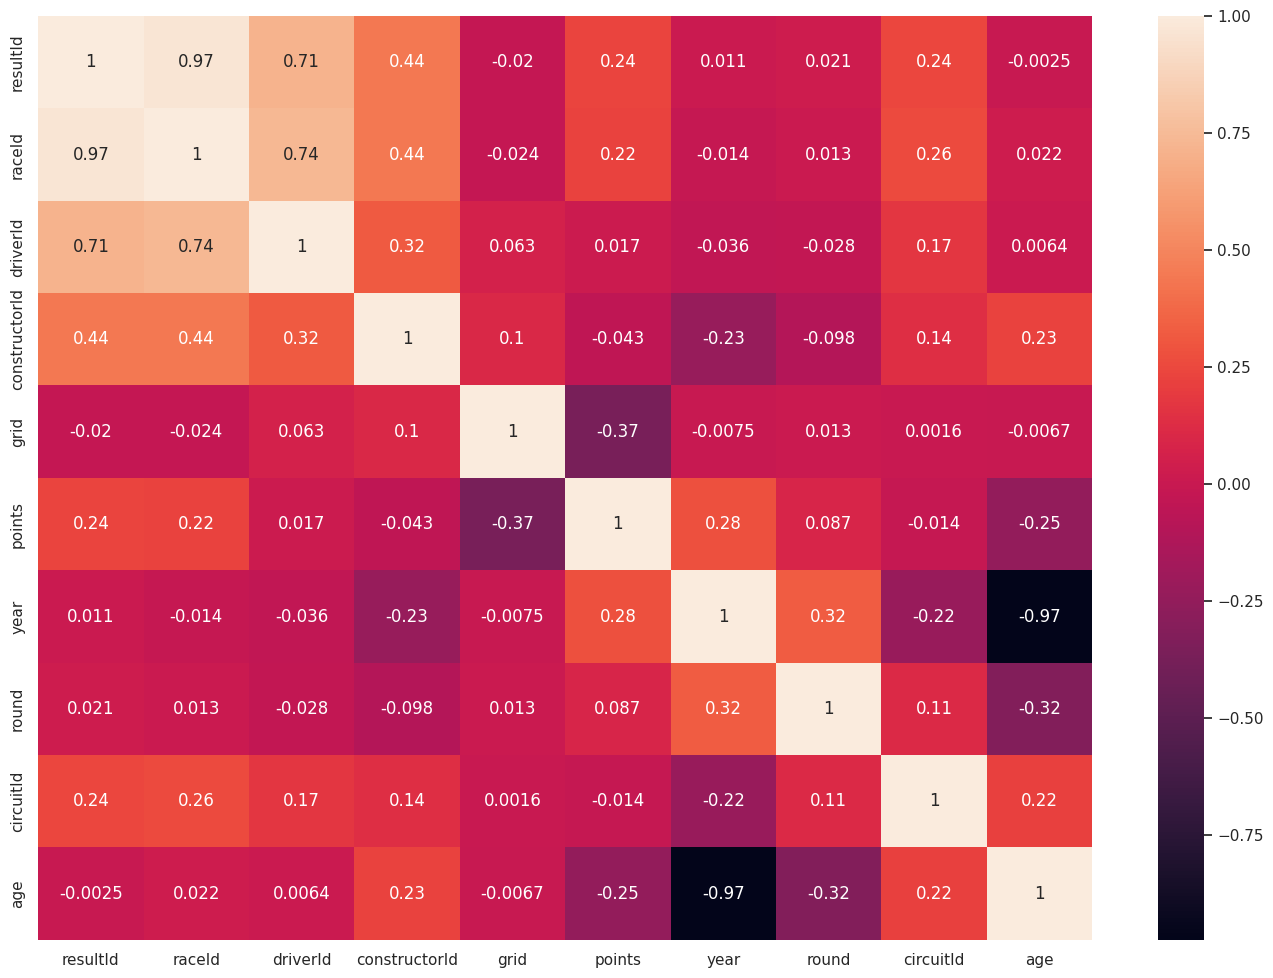

In [23]:
plt.figure(figsize=(17,12))
sns.heatmap(df_race.corr(),annot=True)

In [24]:
#Clasify race as the first half and second half by a new variable first_half
driver_result_withdate_divided = df_race.copy()
driver_result_withdate_divided['firstHalf'] = (driver_result_withdate_divided['date'].dt.month <= 6).astype(int)
driver_result_withdate_divided

,resultId,raceId,driverId,constructorId,grid,points,rank,year,round,circuitId,date,code,forename,surname,dob,age,firstHalf
0,1,18,1,1,1,10.0,2,2008,1,1,2008-03-16,HAM,Lewis,Hamilton,1985-01-07,38.0,1
1,27,19,1,1,9,4.0,3,2008,2,2,2008-03-23,HAM,Lewis,Hamilton,1985-01-07,38.0,1
2,57,20,1,1,3,0.0,19,2008,3,3,2008-04-06,HAM,Lewis,Hamilton,1985-01-07,38.0,1
3,69,21,1,1,5,6.0,3,2008,4,4,2008-04-27,HAM,Lewis,Hamilton,1985-01-07,38.0,1
4,90,22,1,1,3,8.0,2,2008,5,5,2008-05-11,HAM,Lewis,Hamilton,1985-01-07,38.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,25777,1093,855,51,18,0.0,15,2022,19,69,2022-10-23,ZHO,Guanyu,Zhou,1999-05-30,24.0,0
25836,25798,1094,855,51,12,0.0,7,2022,20,32,2022-10-30,ZHO,Guanyu,Zhou,1999-05-30,24.0,0
25837,25817,1095,855,51,13,0.0,17,2022,21,18,2022-11-13,ZHO,Guanyu,Zhou,1999-05-30,24.0,0
25838,25837,1096,855,51,15,0.0,8,2022,22,24,2022-11-20,ZHO,Guanyu,Zhou,1999-05-30,24.0,0


In [25]:
driver_result_withdate_groupby_year_divided = driver_result_withdate_divided.groupby([driver_result_withdate_divided['date'].dt.year, driver_result_withdate_divided['firstHalf'], driver_result_withdate_divided['driverId']])

In [26]:
driver_result_withdate_groupby_year_divided.head()

,resultId,raceId,driverId,constructorId,grid,points,rank,year,round,circuitId,date,code,forename,surname,dob,age,firstHalf
0,1,18,1,1,1,10.0,2,2008,1,1,2008-03-16,HAM,Lewis,Hamilton,1985-01-07,38.0,1
1,27,19,1,1,9,4.0,3,2008,2,2,2008-03-23,HAM,Lewis,Hamilton,1985-01-07,38.0,1
2,57,20,1,1,3,0.0,19,2008,3,3,2008-04-06,HAM,Lewis,Hamilton,1985-01-07,38.0,1
3,69,21,1,1,5,6.0,3,2008,4,4,2008-04-27,HAM,Lewis,Hamilton,1985-01-07,38.0,1
4,90,22,1,1,3,8.0,2,2008,5,5,2008-05-11,HAM,Lewis,Hamilton,1985-01-07,38.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25827,25619,1084,855,51,13,0.0,9,2022,11,70,2022-07-10,ZHO,Guanyu,Zhou,1999-05-30,24.0,0
25828,25641,1085,855,51,16,0.0,18,2022,12,34,2022-07-24,ZHO,Guanyu,Zhou,1999-05-30,24.0,0
25829,25658,1086,855,51,12,0.0,5,2022,13,11,2022-07-31,ZHO,Guanyu,Zhou,1999-05-30,24.0,0
25830,25679,1087,855,51,18,0.0,9,2022,14,13,2022-08-28,ZHO,Guanyu,Zhou,1999-05-30,24.0,0


In [27]:
driver_result_withdate_groupby_year_divided = driver_result_withdate_divided.groupby([driver_result_withdate_divided['date'].dt.year, driver_result_withdate_divided['firstHalf'], driver_result_withdate_divided['driverId']])

point_year_divided = driver_result_withdate_groupby_year_divided["points"].sum().unstack()
display(point_year_divided)

driverId          1    2    3     4    5    6    7    8    9    10   ...  \
date firstHalf                                                       ...   
1950 0            NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
     1            NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
1951 0            NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
     1            NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
1952 0            NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
...               ...  ...  ...   ...  ...  ...  ...  ...  ...  ...  ...   
2020 0          347.0  NaN  NaN   NaN  NaN  NaN  NaN  4.0  NaN  NaN  ...   
2021 0          247.5  NaN  NaN  62.0  NaN  NaN  NaN  9.0  0.0  NaN  ...   
     1          138.0  NaN  NaN  19.0  NaN  NaN  NaN  1.0  NaN  NaN  ...   
2022 0          156.0  NaN  NaN  63.0  NaN  NaN  NaN  NaN  NaN  NaN  ...   
     1           77.0  NaN  NaN  18.0  NaN  NaN  NaN  NaN  NaN  NaN  ...   

driverId          847    848  849  850  851   852  853   854  855  856  
date firstHalf                                                          
1950 0            NaN    NaN  NaN  NaN  NaN   NaN  NaN   NaN  NaN  NaN  
     1            NaN    NaN  NaN  NaN  NaN   NaN  NaN   NaN  NaN  NaN  
1951 0            NaN    NaN  NaN  NaN  NaN   NaN  NaN   NaN  NaN  NaN  
     1            NaN    NaN  NaN  NaN  NaN   NaN  NaN   NaN  NaN  NaN  
1952 0            NaN    NaN  NaN  NaN  NaN   NaN  NaN   NaN  NaN  NaN  
...               ...    ...  ...  ...  ...   ...  ...   ...  ...  ...  
2020 0            3.0  105.0  0.0  0.0  0.0   NaN  NaN   NaN  NaN  NaN  
2021 0           16.0    NaN  7.0  NaN  NaN  23.0  0.0   0.0  NaN  NaN  
     1            0.0    NaN  0.0  NaN  NaN   9.0  0.0   0.0  NaN  NaN  
2022 0          151.0    1.0  2.0  NaN  NaN   1.0  NaN  12.0  1.0  2.0  
     1          111.0    3.0  0.0  NaN  NaN  11.0  NaN   0.0  5.0  NaN  

[145 rows x 855 columns]

In [28]:
age_year = driver_result_withdate_groupby_year_divided["age"].mean().unstack()
age_year

driverId         1    2    3     4    5    6    7     8     9    10   ...  \
date firstHalf                                                        ...   
1950 0           NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  NaN  ...   
     1           NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  NaN  ...   
1951 0           NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  NaN  ...   
     1           NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  NaN  ...   
1952 0           NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  NaN  ...   
...              ...  ...  ...   ...  ...  ...  ...   ...   ...  ...  ...   
2020 0          38.0  NaN  NaN   NaN  NaN  NaN  NaN  44.0   NaN  NaN  ...   
2021 0          38.0  NaN  NaN  42.0  NaN  NaN  NaN  44.0  39.0  NaN  ...   
     1          38.0  NaN  NaN  42.0  NaN  NaN  NaN  44.0   NaN  NaN  ...   
2022 0          38.0  NaN  NaN  42.0  NaN  NaN  NaN   NaN   NaN  NaN  ...   
     1          38.0  NaN  NaN  42.0  NaN  NaN  NaN   NaN   NaN  NaN  ...   

driverId         847   848   849   850   851   852   853   854   855   856  
date firstHalf                                                              
1950 0           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
     1           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1951 0           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
     1           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1952 0           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2020 0          25.0  27.0  28.0  27.0  28.0   NaN   NaN   NaN   NaN   NaN  
2021 0          25.0   NaN  28.0   NaN   NaN  23.0  24.0  24.0   NaN   NaN  
     1          25.0   NaN  28.0   NaN   NaN  23.0  24.0  24.0   NaN   NaN  
2022 0          25.0  27.0  28.0   NaN   NaN  23.0   NaN  24.0  24.0  28.0  
     1          25.0  27.0  28.0   NaN   NaN  23.0   NaN  24.0  24.0   NaN  

[145 rows x 855 columns]

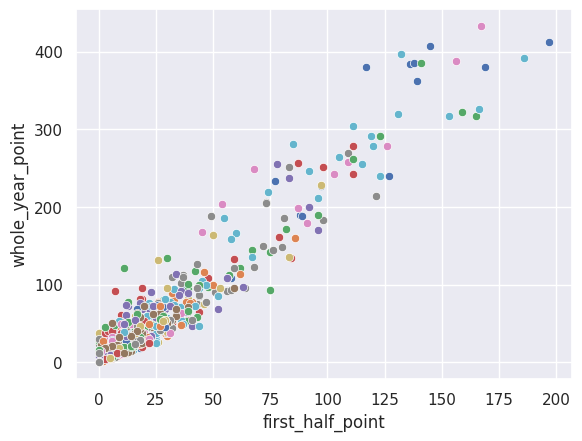

In [29]:
#Loop through each team 
#Column name is ID of each team
df_final = []
id_driver =[]
point_first_half_all = []
whole_year_point_all = []
for column in point_year_divided:
    point_year_driver_divided = point_year_divided[column].unstack()
    point_first_half = []
    whole_year_point = []
    ages = []
    age_one_year = age_year[column].unstack()
    point_year_driver_divided = pd.merge(point_year_driver_divided, age_one_year, on='date')
    #Loop through each year
    for row in point_year_driver_divided.iterrows():
        if not np.isnan(row[1][0]) and not np.isnan(row[1][1]) and (not np.isnan(row[1][2]) or not np.isnan(row[1][3])):
            if not np.isnan(row[1][2]):
                age = row[1][2]
            else:
                age = row[1][3]
            ages.append(age)
            id_driver.append(column)
            point_first_half.append(row[1][1])
            point_first_half_all.append(row[1][1])
            whole_year_point.append(row[1][0]+row[1][1])
            whole_year_point_all.append(row[1][0])
            
    new_df = pd.DataFrame({'first_half_point':point_first_half, 'ages': ages, 'whole_year_point':whole_year_point, 'id_driver':column})
    df_final.append(new_df)
    sns.scatterplot(x='first_half_point', y='whole_year_point', data=new_df)

In [30]:
df_final = pd.concat(df_final, ignore_index=True)

In [31]:
df_final

,first_half_point,ages,whole_year_point,id_driver
0,58.0,38.0,109.0,1
1,38.0,38.0,98.0,1
2,9.0,38.0,49.0,1
3,127.0,38.0,240.0,1
4,97.0,38.0,227.0,1
...,...,...,...,...
1786,11.0,23.0,12.0,852
1787,0.0,24.0,0.0,853
1788,0.0,24.0,0.0,854
1789,0.0,24.0,12.0,854


In [67]:
#df_join = df_final.merge(df_driver, left_on='id_driver', right_on='driverId')
df_join = df_final.merge(this_season_drivers, left_on='id_driver', right_on='driverId')


In [68]:
df_join

,first_half_point,ages,whole_year_point,id_driver,driverId,number_x,forename_x,surname_x,nationality_x,dob_x,...,forename_y,surname_y,dob_y,nationality_y,url,totalRaces,winRate,age,fastestLapRate,qualifyingWinRate
0,58.0,38.0,109.0,1,1,44,Lewis,Hamilton,British,1985-01-07,...,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,311.0,0.33119,38,0.192926,0.340836
1,38.0,38.0,98.0,1,1,44,Lewis,Hamilton,British,1985-01-07,...,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,311.0,0.33119,38,0.192926,0.340836
2,9.0,38.0,49.0,1,1,44,Lewis,Hamilton,British,1985-01-07,...,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,311.0,0.33119,38,0.192926,0.340836
3,127.0,38.0,240.0,1,1,44,Lewis,Hamilton,British,1985-01-07,...,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,311.0,0.33119,38,0.192926,0.340836
4,97.0,38.0,227.0,1,1,44,Lewis,Hamilton,British,1985-01-07,...,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,311.0,0.33119,38,0.192926,0.340836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,7.0,27.0,92.0,848,848,23,Alexander,Albon,Thai,1996-03-23,...,Alexander,Albon,1996-03-23,Thai,http://en.wikipedia.org/wiki/Alexander_Albon,61.0,0.00000,27,0.000000,0.000000
107,3.0,27.0,4.0,848,848,23,Alexander,Albon,Thai,1996-03-23,...,Alexander,Albon,1996-03-23,Thai,http://en.wikipedia.org/wiki/Alexander_Albon,61.0,0.00000,27,0.000000,0.000000
108,9.0,23.0,32.0,852,852,22,Yuki,Tsunoda,Japanese,2000-05-11,...,Yuki,Tsunoda,2000-05-11,Japanese,http://en.wikipedia.org/wiki/Yuki_Tsunoda,45.0,0.00000,23,0.000000,0.000000
109,11.0,23.0,12.0,852,852,22,Yuki,Tsunoda,Japanese,2000-05-11,...,Yuki,Tsunoda,2000-05-11,Japanese,http://en.wikipedia.org/wiki/Yuki_Tsunoda,45.0,0.00000,23,0.000000,0.000000


In [34]:
import pandas as pd

# Assuming your DataFrame is named 'df'
# Use the isnull() method to check for null values
null_values = df_join.isnull().sum()

# Display the count of null values for each column
print(null_values)

first_half_point     0
ages                 0
whole_year_point     0
id_driver            0
driverId             0
number_x             0
forename_x           0
surname_x            0
nationality_x        0
dob_x                0
driverRef            0
number_y             0
code                 0
forename_y           0
surname_y            0
dob_y                0
nationality_y        0
url                  0
totalRaces           0
winRate              0
age                  0
fastestLapRate       0
qualifyingWinRate    0
dtype: int64


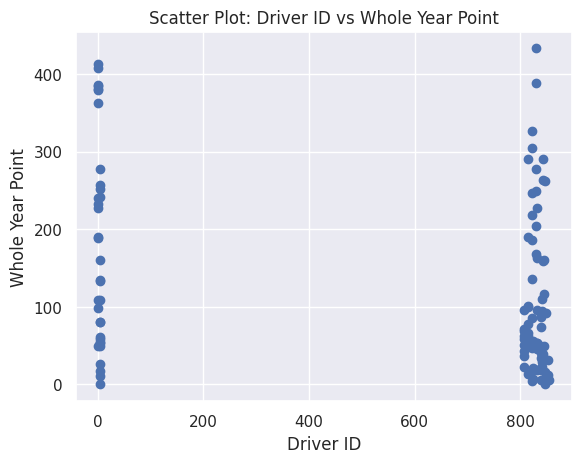

In [69]:
import matplotlib.pyplot as plt

# Create scatter plot
plt.scatter(df_join['driverId'], df_join['whole_year_point'])
plt.xlabel('Driver ID')
plt.ylabel('Whole Year Point')
plt.title('Scatter Plot: Driver ID vs Whole Year Point')

# Display the plot
plt.show()

In [36]:
### SUPERVISED LEARNING SECTION
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor

In [70]:
#linear regression
#Split train and test set
train_x, test_x, train_y, test_y = train_test_split(pd.DataFrame(point_first_half_all), pd.DataFrame(whole_year_point_all), train_size=0.8,random_state=42)
#Train model
linreg = LinearRegression()
linreg.fit(train_x, train_y)
# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()
train_y_hat = linreg.predict(train_x)
test_y_hat = linreg.predict(test_x)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(train_x, train_y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(train_y_hat, train_y))
#print("Root Mean Squared Error (MSE) \t:", np.sqrt(mean_squared_error(train_y_hat, train_y)))
#print()

# Check the Goodness of Fit and Prediction Accuracy (on Test Data)
print("Goodness of Fit of Model and Prediction Accuracy \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(test_x, test_y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(test_y_hat, test_y))

Intercept of Regression 	: b =  [0.67609587]
Coefficients of Regression 	: a =  [[1.30431357]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.814841179900989
Mean Squared Error (MSE) 	: 210.18141989846947
Goodness of Fit of Model and Prediction Accuracy 	Test Dataset
Explained Variance (R^2) 	: 0.7846695288229946
Mean Squared Error (MSE) 	: 180.78847124631415


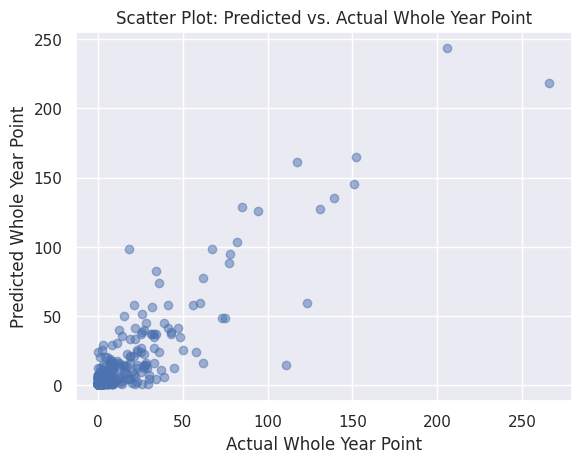

In [71]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(test_y, test_y_hat, alpha=0.5)

# Set plot labels and title
plt.xlabel('Actual Whole Year Point')
plt.ylabel('Predicted Whole Year Point')
plt.title('Scatter Plot: Predicted vs. Actual Whole Year Point')

# Show the plot
plt.show()

In [72]:
# Make predictions using the trained model
predicted_standings = linreg.predict(test_x)

#sorting the result
results = [(forename,surname, points) for forename,surname, points in zip(this_season_drivers['forename_x'],this_season_drivers['surname_x'], predicted_standings)]

sorted_results = sorted(results, key=lambda x: x[2], reverse=True)

for forename,surname, points in sorted_results:
    print(f"Driver: {forename} {surname},\t Predicted points: {points}")

Driver: Kevin Magnussen,	 Predicted points: [58.06589277]
Driver: Oscar Piastri,	 Predicted points: [11.1106044]
Driver: Guanyu Zhou,	 Predicted points: [5.89335013]
Driver: Nico Hülkenberg,	 Predicted points: [5.89335013]
Driver: George Russell,	 Predicted points: [4.58903657]
Driver: Carlos Sainz,	 Predicted points: [4.58903657]
Driver: Lance Stroll,	 Predicted points: [4.58903657]
Driver: Lewis Hamilton,	 Predicted points: [3.284723]
Driver: Fernando Alonso,	 Predicted points: [3.284723]
Driver: Max Verstappen,	 Predicted points: [1.98040944]
Driver: Sergio Pérez,	 Predicted points: [0.67609587]
Driver: Charles Leclerc,	 Predicted points: [0.67609587]
Driver: Yuki Tsunoda,	 Predicted points: [0.67609587]
Driver: Nyck de Vries,	 Predicted points: [0.67609587]
Driver: Lando Norris,	 Predicted points: [0.67609587]
Driver: Esteban Ocon,	 Predicted points: [0.67609587]
Driver: Pierre Gasly,	 Predicted points: [0.67609587]
Driver: Valtteri Bottas,	 Predicted points: [0.67609587]
Driver: L

In [73]:
#the prediction was not that accurate so we introduced more variables to predict, including winRate,fastestLapRate and qualifyingWinRate
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Ensure the data is in the right format
features = ['first_half_point', 'winRate', 'fastestLapRate', 'qualifyingWinRate']
df_join[features] = df_join[features].apply(pd.to_numeric, errors='coerce')

# Extract the features and target variables
X = df_join[features]
y = df_join['whole_year_point']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Output model performance metrics
print("Coefficients: ", model.coef_)
print("Intercept: ", model.intercept_)
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE): %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score (R^2): %.2f' % r2_score(y_test, y_pred))
print('Mean Absolute Error (MAE): %.2f' % mean_absolute_error(y_test, y_pred))

Coefficients:  [  2.23048007  87.75753169 -35.84630338  19.71398842]
Intercept:  7.236072445507631
Mean squared error (MSE): 1119.26
Root Mean Squared Error (RMSE): 33.46
Variance score (R^2): 0.93
Mean Absolute Error (MAE): 26.74


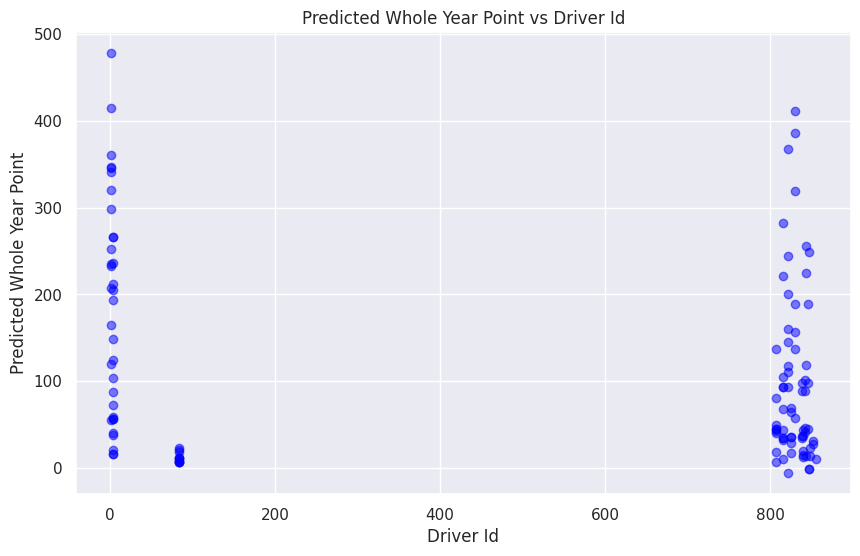

In [40]:
import matplotlib.pyplot as plt

# Make predictions on the entire dataset for plotting
df_join['predicted_whole_year_point'] = model.predict(df_join[features])

# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df_join['driverId'], df_join['predicted_whole_year_point'], color='blue', alpha=0.5)
plt.xlabel('Driver Id')
plt.ylabel('Predicted Whole Year Point')
plt.title('Predicted Whole Year Point vs Driver Id')
plt.grid(True)
plt.show()

In [76]:
# Make predictions using the trained model
predicted_standings = model.predict(X_test)

#sorting the result
results = [(forename,surname, points) for forename,surname, points in zip(this_season_drivers['forename_x'],this_season_drivers['surname_x'], predicted_standings)]

sorted_results = sorted(results, key=lambda x: x[2], reverse=True)

for forename,surname, points in sorted_results:
    print(f"Driver: {forename} {surname},\t Predicted points: {points}")

Driver: Nyck de Vries,	 Predicted points: 359.5236258678017
Driver: George Russell,	 Predicted points: 346.14074544463335
Driver: Max Verstappen,	 Predicted points: 252.46058248245495
Driver: Alexander Albon,	 Predicted points: 175.0143782158322
Driver: Esteban Ocon,	 Predicted points: 165.4718597318607
Driver: Logan Sargeant,	 Predicted points: 159.50527347151893
Driver: Guanyu Zhou,	 Predicted points: 145.58563696680818
Driver: Valtteri Bottas,	 Predicted points: 143.7876572284394
Driver: Pierre Gasly,	 Predicted points: 118.87987230361878
Driver: Oscar Piastri,	 Predicted points: 74.27027089305761
Driver: Lewis Hamilton,	 Predicted points: 72.03979082252955
Driver: Lando Norris,	 Predicted points: 69.8093107520015
Driver: Kevin Magnussen,	 Predicted points: 42.68311182242067
Driver: Carlos Sainz,	 Predicted points: 38.13994487183367
Driver: Yuki Tsunoda,	 Predicted points: 36.80021224031255
Driver: Lance Stroll,	 Predicted points: 34.20236406173729
Driver: Sergio Pérez,	 Predicted p

In [77]:
#Polynomial Regression

#Split train and test set
train_x, test_x, train_y, test_y = train_test_split(pd.DataFrame(point_first_half_all), pd.DataFrame(whole_year_point_all), train_size=0.8)
polynomial_features= PolynomialFeatures(degree=2)
train_x_poly = polynomial_features.fit_transform(train_x)
test_x_poly = polynomial_features.fit_transform(test_x)
#Train model
polreg = LinearRegression()
polreg.fit(train_x_poly, train_y)
# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', polreg.intercept_)
print('Coefficients of Regression \t: a = ', polreg.coef_)
print()
train_y_hat = polreg.predict(train_x_poly)
test_y_hat = polreg.predict(test_x_poly)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Accuracy score\t:", polreg.score(train_x_poly, train_y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(train_y_hat, train_y))
#print("Root Mean Squared Error (MSE) \t:", np.sqrt(mean_squared_error(train_y_hat, train_y)))
#print()

# Check the Goodness of Fit and Prediction Accuracy (on Test Data)
print("Goodness of Fit of Model and Prediction Accuracy \tTest Dataset")
print("Accuracy score \t:", polreg.score(test_x_poly, test_y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(test_y_hat, test_y))

Intercept of Regression 	: b =  [1.52222792]
Coefficients of Regression 	: a =  [[0.00000000e+00 1.17714989e+00 6.62046331e-04]]

Goodness of Fit of Model 	Train Dataset
Accuracy score	: 0.8034129966657559
Mean Squared Error (MSE) 	: 201.3718684091805
Goodness of Fit of Model and Prediction Accuracy 	Test Dataset
Accuracy score 	: 0.8390972632175575
Mean Squared Error (MSE) 	: 206.4229688471894


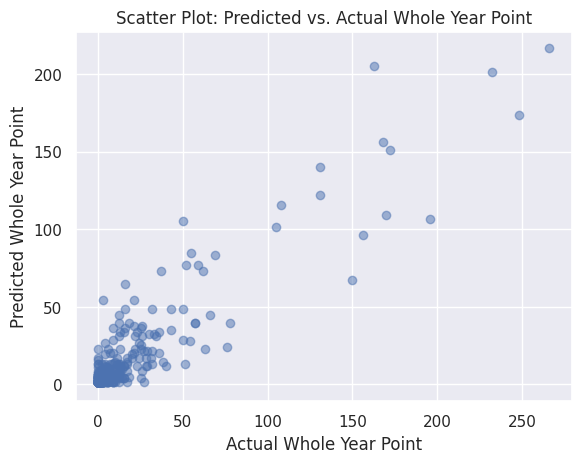

In [78]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(test_y, test_y_hat, alpha=0.5)

# Add a diagonal line representing ideal prediction
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color='red')

# Set plot labels and title
plt.xlabel('Actual Whole Year Point')
plt.ylabel('Predicted Whole Year Point')
plt.title('Scatter Plot: Predicted vs. Actual Whole Year Point')

# Show the plot
plt.show()

In [79]:
# Make predictions using the trained model
predicted_standings = polreg.predict(train_x_poly)

#sorting the result
results = [(forename,surname, points) for forename,surname, points in zip(this_season_drivers['forename_x'],this_season_drivers['surname_x'], predicted_standings)]

sorted_results = sorted(results, key=lambda x: x[2], reverse=True)

for forename,surname, points in sorted_results:
    print(f"Driver: {forename} {surname},\t Predicted points: {points}")

Driver: Guanyu Zhou,	 Predicted points: [110.23830485]
Driver: Sergio Pérez,	 Predicted points: [58.310733]
Driver: Yuki Tsunoda,	 Predicted points: [55.8346167]
Driver: Lance Stroll,	 Predicted points: [41.08914268]
Driver: Max Verstappen,	 Predicted points: [37.43256626]
Driver: Esteban Ocon,	 Predicted points: [30.15516392]
Driver: Fernando Alonso,	 Predicted points: [28.94689785]
Driver: Alexander Albon,	 Predicted points: [12.17020266]
Driver: Lewis Hamilton,	 Predicted points: [9.79471741]
Driver: Nico Hülkenberg,	 Predicted points: [5.059636]
Driver: Nyck de Vries,	 Predicted points: [3.87917588]
Driver: Valtteri Bottas,	 Predicted points: [3.87917588]
Driver: George Russell,	 Predicted points: [1.52222792]
Driver: Charles Leclerc,	 Predicted points: [1.52222792]
Driver: Carlos Sainz,	 Predicted points: [1.52222792]
Driver: Lando Norris,	 Predicted points: [1.52222792]
Driver: Oscar Piastri,	 Predicted points: [1.52222792]
Driver: Pierre Gasly,	 Predicted points: [1.52222792]
Dr

In [80]:
#Polynomial Regression using features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the feature columns
features = ['first_half_point', 'winRate', 'fastestLapRate', 'qualifyingWinRate']

# Split the data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(df_join[features], df_join['whole_year_point'], train_size=0.8, random_state=42)

# Define Polynomial Features
polynomial_features= PolynomialFeatures(degree=2)

# Transform both the train and test data
train_x_poly = polynomial_features.fit_transform(train_x)
test_x_poly = polynomial_features.transform(test_x)

# Train the model
polreg = LinearRegression()
polreg.fit(train_x_poly, train_y)

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', polreg.intercept_)
print('Coefficients of Regression \t: a = ', polreg.coef_)
print()

# Predict for both train and test data
train_y_hat = polreg.predict(train_x_poly)
test_y_hat = polreg.predict(test_x_poly)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Accuracy score\t:", polreg.score(train_x_poly, train_y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(train_y_hat, train_y))
print()

# Check the Goodness of Fit and Prediction Accuracy (on Test Data)
print("Goodness of Fit of Model and Prediction Accuracy \tTest Dataset")
print("Accuracy score \t:", polreg.score(test_x_poly, test_y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(test_y_hat, test_y))

Intercept of Regression 	: b =  17.514157282337166
Coefficients of Regression 	: a =  [ 0.00000000e+00  2.10991137e+00  9.21787189e+02 -1.00945512e+03
 -5.81651201e+02 -1.01108042e-03 -6.08806707e-01  3.01334806e+00
  1.61204040e-01 -5.38175805e+03  4.95795405e+03 -3.30510127e+03
  1.41966878e+04 -1.04501305e+04  7.65377076e+03]

Goodness of Fit of Model 	Train Dataset
Accuracy score	: 0.9365456407716677
Mean Squared Error (MSE) 	: 811.638907535475

Goodness of Fit of Model and Prediction Accuracy 	Test Dataset
Accuracy score 	: 0.9388510593010224
Mean Squared Error (MSE) 	: 949.7028686710223


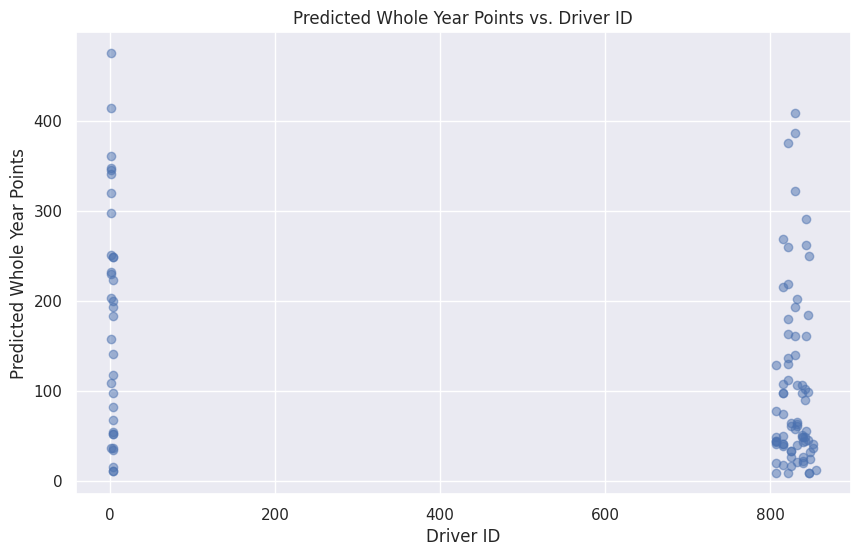

In [81]:
import matplotlib.pyplot as plt

# Suppose 'predictions' is the array of predicted whole year points.
# Adding a new column to the DataFrame for these predictions
df_join['predicted_whole_year_points'] = polreg.predict(polynomial_features.transform(df_join[features]))

# Now, to create the scatter plot:
plt.figure(figsize=(10, 6))
plt.scatter(df_join['driverId'], df_join['predicted_whole_year_points'], alpha=0.5)
plt.title('Predicted Whole Year Points vs. Driver ID')
plt.xlabel('Driver ID')
plt.ylabel('Predicted Whole Year Points')
plt.show()

In [82]:
# Make predictions using the trained model
predicted_standings = polreg.predict(train_x_poly)

#sorting the result
results = [(forename,surname, points) for forename,surname, points in zip(this_season_drivers['forename_x'],this_season_drivers['surname_x'], predicted_standings)]

sorted_results = sorted(results, key=lambda x: x[2], reverse=True)

for forename,surname, points in sorted_results:
    print(f"Driver: {forename} {surname},\t Predicted points: {points}")

Driver: Nyck de Vries,	 Predicted points: 297.4547983211941
Driver: Logan Sargeant,	 Predicted points: 269.39366282938806
Driver: Lewis Hamilton,	 Predicted points: 249.3779521268155
Driver: Valtteri Bottas,	 Predicted points: 229.67290009109746
Driver: Oscar Piastri,	 Predicted points: 136.6081678252798
Driver: Alexander Albon,	 Predicted points: 111.54717636537178
Driver: Fernando Alonso,	 Predicted points: 97.22375137577404
Driver: Max Verstappen,	 Predicted points: 82.40217672399784
Driver: Esteban Ocon,	 Predicted points: 57.43720402322175
Driver: Lando Norris,	 Predicted points: 51.49510627062375
Driver: Nico Hülkenberg,	 Predicted points: 48.774488919920856
Driver: Guanyu Zhou,	 Predicted points: 44.574212911407585
Driver: Yuki Tsunoda,	 Predicted points: 42.679983579125604
Driver: Kevin Magnussen,	 Predicted points: 42.47104166588113
Driver: Sergio Pérez,	 Predicted points: 41.04137448671109
Driver: George Russell,	 Predicted points: 35.892942221715415
Driver: Lance Stroll,	 Pr